In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
indexed_by_target_path = 'data/clean/protein/indexed_by_target.csv'
clinical_path = 'data/clean/protein/clinical_data_ordered_to_match_proteins_matrix.csv'

raw_gene_path = 'data/clean/protein/gene_levels_by_entrez.csv'
target_to_entrez_path = 'data/clean/protein/protein_to_entrez.csv'

log_matrix_filtered_path = 'data/clean/protein/log_10_filtered.csv'

In [4]:
clinical = read_csv(clinical_path, index_col=0)
raw_protein_matrix = read_csv(indexed_by_target_path, index_col=0)

In [5]:
# note: this is already limitted to the patients having the protein measurments
by_condition = clinical.Meningitis

In [6]:
%%R -i raw_protein_matrix -i by_condition
import::here(space_to_dot, dot_to_space, .from='helpers/utilities.R')
import::here(
    design_from_conditions, calculate_means, limma_fit,
    .from='helpers/differential_expression.R'
)

In [7]:
protein_matrix = read_csv(log_matrix_filtered_path, index_col=0)

In [8]:
%%R -i by_condition -i protein_matrix

limma_protein_fit = function(data=protein_matrix, conditions_vector=by_condition, ...) {
    limma_fit(data=data, conditions_vector=conditions_vector, ...)
}

diff_ebayes <- function(a, b, ...) {
    fit = limma_protein_fit(a=a, b=b, ...)
    limma::eBayes(fit, trend=T, robust=T)
}

## Gene set enrichment

In [9]:
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase

db = MolecularSignaturesDatabase('data/msigdb', version='6.2')

In [10]:
from helpers.gse import collection_to_R, formatter_to_fix_letter_case, calculate_overlap

Actually, the GMT files in MSigDB are old (released 16-Jul-2018 as a point release with only minor changes).

Let's fetch a recent GMT directly from Reactome; `data/ReactomePathways.gmt`, downloaded with `download.sh` script on:

In [11]:
!ls data/ReactomePathways.gmt -l

-rw-r--r-- 1 krassowski krassowski 845606 Mar 12 16:56 data/ReactomePathways.gmt


In [12]:
from gsea_api.molecular_signatures_db import GeneMatrixTransposed

In [13]:
reactome_new_symbol = GeneMatrixTransposed.from_gmt('data/ReactomePathways.gmt', name='reactome_new_symbol')

# use the recent Reactome to improve the pathways name formatting in MSigDB for increased readability 
try_to_fix_letter_case = formatter_to_fix_letter_case(reactome_new_symbol)

reactome_pathways_entrez = db.load(gene_sets='c2.cp.reactome', id_type='entrez').format_names(try_to_fix_letter_case)
reactome_pathways_symbol = db.load(gene_sets='c2.cp.reactome', id_type='symbols').format_names(try_to_fix_letter_case)

/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:61: UserWarning: Provided gene sets are not redundant; there are 117 gene sets having more than one name assigned; use find_redundant() to investigate further.
  warn(message)


Simple symbol-based protein-gene matching performs poorly:

In [14]:
calculate_overlap(reactome_pathways_symbol, protein_matrix)

12.92%


And the full, recent Reactome version provides only moderate improvement:

In [15]:
calculate_overlap(reactome_new_symbol, protein_matrix)

21.08%


Instead I will use Entrez ID based mapping, as described in [Gene_level_mapping.ipynb](Gene_level_mapping.ipynb) notebook:

In [16]:
raw_gene_matrix = read_csv(raw_gene_path, index_col=0)

In [17]:
assert not raw_gene_matrix.index.duplicated().any()

In [18]:
from numpy import log10

In [19]:
log10_gene_matrix = raw_gene_matrix.apply(log10)

It matches much more genes:

In [20]:
calculate_overlap(reactome_pathways_entrez, raw_gene_matrix)

55.50%


In [21]:
kegg_pathways_entrez = db.load(gene_sets='c2.cp.kegg', id_type='entrez')
calculate_overlap(reactome_pathways_entrez, raw_gene_matrix)

55.50%


In [22]:
id_to_symbol = read_table('data/hgnc/entrez_to_gene_symbol.tsv', index_col=0)['Approved symbol']

In [23]:
id_to_symbol.head()

NCBI Gene ID
51704.0           GPRC5B
29765.0            TMOD4
54676.0           GTPBP2
105369454.0    LINC02713
23768.0            FLRT2
Name: Approved symbol, dtype: object

In [24]:
from numpy import nan

In [25]:
symbols = raw_gene_matrix.index.map(lambda entrez_id: id_to_symbol.get(float(entrez_id), nan))
raw_gene_matrix_by_symbols = copy(raw_gene_matrix)
raw_gene_matrix_by_symbols.index = symbols

In [26]:
genes_missing_symbols = raw_gene_matrix.index[raw_gene_matrix_by_symbols.index.isnull()]
sorted(genes_missing_symbols)

[4233,
 4276,
 4481,
 5136,
 8600,
 10288,
 12372,
 51330,
 64806,
 91179,
 1489079,
 1489089,
 1724716,
 100293534]

In [27]:
# reflects state for 16 Apr 2020
manual_map = {
    4276.0: 'MICA',
    100293534: 'C4B_2',
    51330: 'TNFRSF12A',
    64806: 'IL25',
    91179: 'SCARF2',
    4481: 'MSR1',
    5136: 'PDE1A',
    8600: 'TNFSF11',
    10288: 'LILRB2',
    4233: 'MET'
}

- 4276 - replaced with 100507436 but symbol stayed the same (MICA)
   > Gene ID: 4276, discontinued on 10-Nov-2010
   >
  > This record was replaced with Gene ID: 100507436
- 12372 - mouse protein
- 1489079, 1489089, 1724716 - viral proteins

In [28]:
id_to_symbol_curated = {**id_to_symbol, **manual_map}

In [29]:
symbols_curated = raw_gene_matrix.index.map(lambda entrez_id: id_to_symbol_curated.get(float(entrez_id), nan))

In [30]:
raw_gene_matrix_by_symbols.index = symbols_curated
raw_gene_matrix_by_symbols = raw_gene_matrix_by_symbols[~raw_gene_matrix_by_symbols.index.isnull()]

However, MICA and ICOSLG are already captured by other entrez ids - so I can remove the duplicates:

In [31]:
raw_gene_matrix_by_symbols[raw_gene_matrix_by_symbols.index.duplicated(keep=False)]

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
MICA,51.75,207.25,5.65,7.05,22.0,...,10.45,11.85,6.65,11.6,11.95
MICA,51.75,207.25,5.65,7.05,22.0,...,10.45,11.85,6.65,11.6,11.95


In [32]:
raw_gene_matrix_by_symbols = raw_gene_matrix_by_symbols[~raw_gene_matrix_by_symbols.index.duplicated()]

In [33]:
calculate_overlap(reactome_new_symbol, raw_gene_matrix_by_symbols)

86.09%


Using the recent Reactome GMT mapped via entrez IDs to symbol seems good enough. Is it superior to just using the symbols provided in aptamers metadata?

In [34]:
aptamers = read_csv('data/other/relevant_aptamers.csv')

In [35]:
soma = set(symbol for symbols in aptamers.EntrezGeneSymbol.str.split(' ') for symbol in symbols)
precentage = len(reactome_new_symbol.all_genes & soma) / len(soma) * 100
precentage

86.73312883435584

In [36]:
len(soma), len(raw_gene_matrix_by_symbols)

(1304, 1323)

It's about the same. But I feel much more confident using the entrez-id mapping step.

In [37]:
entrez_ids = set(map(str, raw_gene_matrix.index))
symbols = set(raw_gene_matrix_by_symbols.index)

for collection, genes in [
    (kegg_pathways_entrez, entrez_ids),
    (reactome_new_symbol, symbols),
    (reactome_pathways_entrez, entrez_ids)
]:
    after_trimming = collection_to_R(collection, trim_to=genes)
    print(collection.name, len(after_trimming))

c2.cp.kegg 103
reactome_new_symbol 760
c2.cp.reactome 297


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'KEGG_FATTY_ACID_METABOLISM' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'KEGG_ASCORBATE_AND_ALDARATE_METABOLISM' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'KEGG_AMINOACYL_TRNA_BIOSYNTHESIS' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7

In [38]:
%%R
gse = function(data, groups, contrast, collection, nrot=9999){
    design = design_from_conditions(groups, intercept='Healthy.control')
    limma::mroast(data, collection, design=design, contrast=contrast, geneid=dimnames(data)[[1]], nrot=nrot)
}

In [39]:
log10_gene_matrix_symbols = raw_gene_matrix_by_symbols.apply(log10)

## Simple multiple rotational GSE testing is not well suited to prioritetize pathways in imbalanced dataset

Because ROAST is self-contained it performs poorly in a setting where everything is up:

### The results from recent Reactome release uncover more hits

In [40]:
%R -i log10_gene_matrix -i log10_gene_matrix_symbols
%R head(gse(log10_gene_matrix, by_condition, 'Tuberculosis', c2.cp.reactome))

,NGenes,PropDown,PropUp,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
Apoptosis,42,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Integrin cell surface interactions,38,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Cell Cycle,34,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Signaling by the B Cell Receptor (BCR),28,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Costimulation by the CD28 family,26,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Cell Cycle Mitotic,26,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001


In [41]:
%R head(gse(log10_gene_matrix_symbols, by_condition, 'Tuberculosis', reactome_new_symbol))

,NGenes,PropDown,PropUp,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
Cell Cycle,69,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
"Cell Cycle, Mitotic",59,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Transcriptional Regulation by TP53,58,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Programmed Cell Death,56,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Apoptosis,55,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001
Signaling by VEGF,41,0.0,1.0,Up,0.0001,0.0001,0.0001,0.0001


## Camera (after limma with trend correction) is better suited for the imbalanced dataset

- Because it is a competitive test.
- because we take advantage of the mean-variance trend correction and robust statistics

In [42]:
%%R
camera = function(a, b, data, collection, design=by_condition, ...) {
    result = diff_ebayes(a, b, data=data, conditions_vector=design, ...)
    # using t-statistic
    limma::cameraPR(result$t[,1], collection)
}

TODO maybe use voom, maybe use normal camera: there are lessons learned during RNASeq analysis to be backported here

In [43]:
%%R -o tb_log_msig
tb_log_msig = camera('Tuberculosis', 'Healthy control', log10_gene_matrix, c2.cp.reactome)

In [44]:
tb_log_msig.head(10)

,NGenes,Direction,PValue,FDR
RNA Pol I Promoter Opening,13.0,Up,1.635869e-11,4.858532e-09
RNA Pol I Transcription,14.0,Up,8.811001e-11,1.308434e-08
Meiosis,16.0,Up,3.623204e-10,3.586972e-08
Meiotic recombination,14.0,Up,7.073650e-10,5.252185e-08
RNA Pol I RNA Pol Iii And Mitochondrial Transcription,16.0,Up,1.324177e-09,7.865614e-08
Transcription,18.0,Up,5.071368e-09,2.510327e-07
Factors involved in megakaryocyte development and platelet production,25.0,Up,8.426624e-05,3.575296e-03
Signaling by SCF-KIT,38.0,Up,2.342591e-04,8.696868e-03
Heparan sulfate/heparin (HS-GAG) metabolism,10.0,Down,3.399709e-04,1.121904e-02
Glycosaminoglycan metabolism,20.0,Down,5.470942e-04,1.607612e-02


In [45]:
%%R -o tb_log_new
tb_log_new = camera('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols, reactome_new_symbol)

In [46]:
tb_log_new.head(10)

,NGenes,Direction,PValue,FDR
Signaling by Rho GTPases,39.0,Up,0.000170,0.051507
Activation of BAD and translocation to mitochondria,12.0,Up,0.000210,0.051507
Cell Cycle,69.0,Up,0.000241,0.051507
Neutrophil degranulation,128.0,Up,0.000271,0.051507
Heparan sulfate/heparin (HS-GAG) metabolism,10.0,Down,0.000344,0.052318
Glycosaminoglycan metabolism,20.0,Down,0.000552,0.052743
Chondroitin sulfate/dermatan sulfate metabolism,11.0,Down,0.000723,0.052743
Intrinsic Pathway for Apoptosis,25.0,Up,0.000749,0.052743
Apoptosis,55.0,Up,0.000793,0.052743
RHO GTPase Effectors,35.0,Up,0.000803,0.052743


Some familiar names here:
 - "Activation of BAD and translocation to mitochondria", "Cell Cycle" (highlighted by ORA)
 - RHO GTPase and Neutrophil degranulation - there are frequent mentions in context of TB

Note:
- Using the full Reactome dataset has an advantage of increased (86% from 55%) number of genes mapped to the pathways
- but it might introduce too similar (correlated) gene sets which skew the results of tests - which is not the case for the curated collections
- when an agreement between the two methods is reached, we can rest assured that the results are correct

In [47]:
def agreement(a, b, cutoff=0.1):
    a = copy(a)
    b = copy(b)
    b['name'] = b.index
    a.index = a.index.str.lower()
    b.index = b.index.str.lower()
    for d in [a, b]:
        # this code wants to be rewritten to a regexpr
        d.index = d.index.map(lambda x: ''.join([
            c if c.isalnum() or c.isspace() else ' '
            for c in x
        ]).replace('  ', ' ').replace('  ', ' '))
    agreement = set(a[a.FDR < cutoff].index) & set(b[b.FDR < cutoff].index)
    return a.loc[agreement].merge(b.loc[agreement], left_index=True, right_index=True).sort_values('FDR_y').set_index('name')

In [48]:
tb_log_agreement = agreement(tb_log_msig, tb_log_new, cutoff=0.1)
tb_log_agreement

,NGenes_x,Direction_x,PValue_x,FDR_x,NGenes_y,Direction_y,PValue_y,FDR_y
name,,,,,,,,
Heparan sulfate/heparin (HS-GAG) metabolism,10.0,Down,0.000340,0.011219,10.0,Down,0.000344,0.052318
Glycosaminoglycan metabolism,20.0,Down,0.000547,0.016076,20.0,Down,0.000552,0.052743
Chondroitin sulfate/dermatan sulfate metabolism,11.0,Down,0.000716,0.017719,11.0,Down,0.000723,0.052743
CS/DS degradation,6.0,Down,0.000892,0.020368,6.0,Down,0.000902,0.052743
Apoptosis,42.0,Up,0.004922,0.060912,55.0,Up,0.000793,0.052743
Metabolism of RNA,23.0,Up,0.001855,0.036475,34.0,Up,0.001893,0.072002
HS-GAG degradation,6.0,Down,0.002472,0.038644,6.0,Down,0.002496,0.079130
Signaling by the B Cell Receptor (BCR),28.0,Up,0.000595,0.016076,27.0,Up,0.002515,0.079130
Costimulation by the CD28 family,26.0,Up,0.002307,0.038067,28.0,Up,0.002603,0.079130


In [49]:
%R import::here(barplot, .from='plots/differential_expression.R')

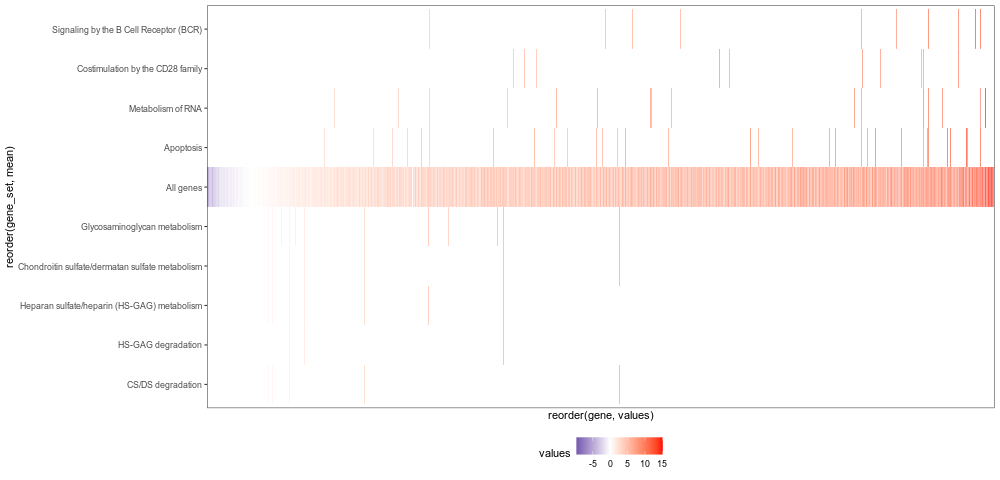

In [50]:
%%R -w 1000 -u px -i tb_log_agreement
sets_of_interest = rownames(tb_log_agreement)
result = diff_ebayes('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols)
barplot(result$t[,1], sets_of_interest, reactome_new_symbol)

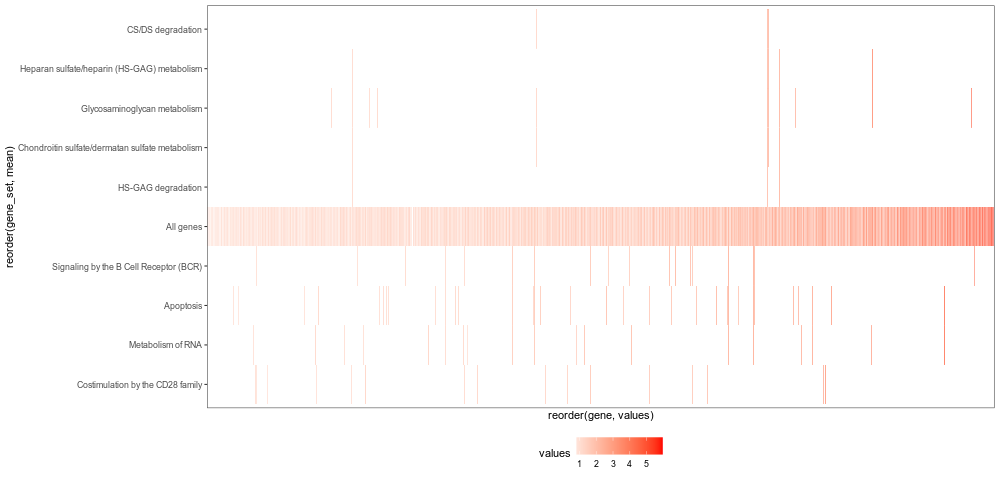

In [51]:
%%R -w 1000 -u px
barplot(rowMeans(log10_gene_matrix_symbols), sets_of_interest, reactome_new_symbol)

### TB vs crypto

In [52]:
%%R -o tb_cc_log_msig
tb_cc_log_msig = camera('Tuberculosis', 'Cryptococcal', log10_gene_matrix, c2.cp.reactome, intercept='Healthy.control')

In [53]:
tb_cc_log_msig.head(10)

,NGenes,Direction,PValue,FDR
RNA Pol I Promoter Opening,13.0,Up,4.323392e-07,0.000063
Transcription,18.0,Up,5.776950e-07,0.000063
Meiosis,16.0,Up,9.298226e-07,0.000063
RNA Pol I Transcription,14.0,Up,9.740679e-07,0.000063
RNA Pol I RNA Pol Iii And Mitochondrial Transcription,16.0,Up,1.251975e-06,0.000063
Meiotic recombination,14.0,Up,1.263660e-06,0.000063
Signaling by SCF-KIT,38.0,Up,8.172988e-06,0.000347
Peptide hormone biosynthesis,8.0,Down,5.207938e-05,0.001933
Signaling by the B Cell Receptor (BCR),28.0,Up,9.132370e-05,0.003014
Glycoprotein hormones,7.0,Down,1.161016e-04,0.003448


In [54]:
%%R -o tb_cc_log_new
tb_cc_log_new = camera('Tuberculosis', 'Cryptococcal', log10_gene_matrix_symbols, reactome_new_symbol, intercept='Healthy.control')

In [55]:
tb_cc_log_new.head(10)

,NGenes,Direction,PValue,FDR
Cell Cycle,69.0,Up,0.000020,0.013337
"Cell Cycle, Mitotic",59.0,Up,0.000042,0.013337
Peptide hormone biosynthesis,8.0,Down,0.000053,0.013337
Glycoprotein hormones,7.0,Down,0.000117,0.022279
Assembly of collagen fibrils and other multimeric structures,10.0,Down,0.000198,0.030149
M Phase,38.0,Up,0.000254,0.032130
Signaling by Rho GTPases,39.0,Up,0.000375,0.040083
CREB1 phosphorylation through NMDA receptor-mediated activation of RAS signaling,8.0,Up,0.000442,0.040083
Signaling by SCF-KIT,24.0,Up,0.000475,0.040083
Collagen degradation,17.0,Down,0.000812,0.061497


In [56]:
show_table(agreement(tb_cc_log_msig, tb_cc_log_new, cutoff=0.1))

,NGenes_x,Direction_x,PValue_x,FDR_x,NGenes_y,Direction_y,PValue_y,FDR_y
name,,,,,,,,
Peptide hormone biosynthesis,8.0,Down,0.000052,0.001933,8.0,Down,0.000053,0.013337
Cell Cycle,34.0,Up,0.007341,0.056209,69.0,Up,0.000020,0.013337
Glycoprotein hormones,7.0,Down,0.000116,0.003448,7.0,Down,0.000117,0.022279
Signaling by SCF-KIT,38.0,Up,0.000008,0.000347,24.0,Up,0.000475,0.040083
Apoptosis,42.0,Up,0.010565,0.066686,55.0,Up,0.001466,0.061755
Post NMDA receptor activation events,7.0,Up,0.002936,0.034646,22.0,Up,0.001915,0.061755
Signalling to ERKs,20.0,Up,0.003939,0.038999,18.0,Up,0.005107,0.074085
Metabolism of RNA,23.0,Up,0.007949,0.056209,34.0,Up,0.003603,0.074085
PIP3 activates AKT signaling,9.0,Up,0.005979,0.050883,81.0,Up,0.003127,0.074085


TODO: Cell cycle - what makes it come

In [57]:
%R import::here(gene_set_heatmap, .from='plots/differential_expression.R')

In [58]:
from plots.annotations import generate_patient_annotations
counts_patient_annotations = generate_patient_annotations(clinical)

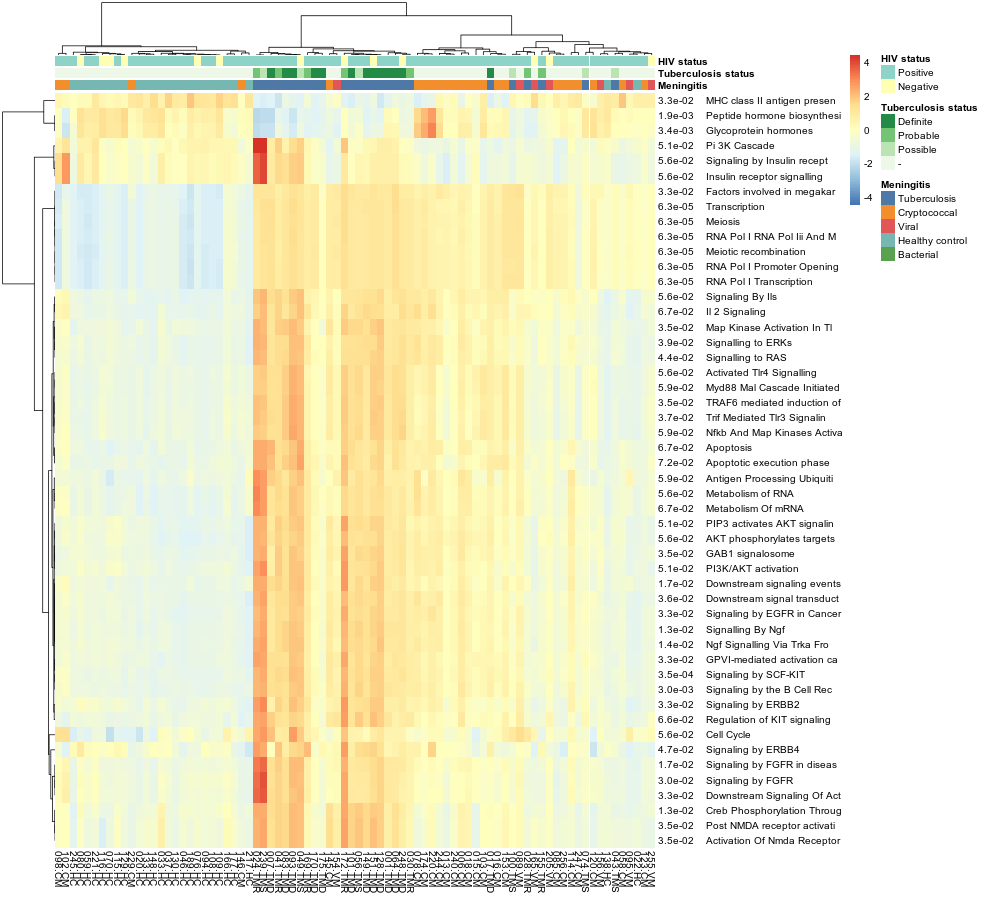

In [59]:
%%R -w 1000 -h 900 -i counts_patient_annotations

# TODO: handle the globals below
names(counts_patient_annotations) = dot_to_space(names(counts_patient_annotations))
outliers=c()

# TODO: use complex heatmap instead
gene_set_heatmap(
    head(tb_cc_log_msig, 50), log10_gene_matrix,
    collection=c2.cp.reactome, id_type=NULL
)

## HIV?

In [60]:
hiv_status = clinical.HIVResult

In [61]:
%%R -i hiv_status -o hiv_pos_vs_neg
hiv_pos_vs_neg = camera('Positive', '(Intercept)', log10_gene_matrix, c2.cp.reactome, design=hiv_status)

In [62]:
hiv_pos_vs_neg.head(10)

,NGenes,Direction,PValue,FDR
Regulation of Complement cascade,8.0,Down,2.872949e-09,8.532659e-07
Complement cascade,22.0,Down,6.034508e-08,8.961244e-06
Common Pathway,10.0,Down,6.436680e-07,6.372313e-05
Regulation Of Insulin Like Growth Factor Igf Activity By Insulin Like Growth Factor Binding Proteins Igfbps,13.0,Down,2.261444e-06,1.679122e-04
Hdl Mediated Lipid Transport,6.0,Down,2.963196e-06,1.760139e-04
Initial triggering of complement,11.0,Down,1.427589e-05,7.066565e-04
G alpha (q) signalling events,16.0,Down,3.028667e-04,1.285020e-02
Lipoprotein Metabolism,9.0,Down,6.187618e-04,2.297153e-02
Formation of Fibrin Clot (Clotting Cascade),22.0,Down,1.085712e-03,3.582849e-02
Lipid Digestion Mobilization And Transport,10.0,Down,2.008847e-03,5.187171e-02


In [63]:
%%R -i hiv_status -o hiv_pos_vs_neg_new
hiv_pos_vs_neg_new = camera('Positive', '(Intercept)', log10_gene_matrix_symbols, reactome_new_symbol, design=hiv_status)

In [64]:
hiv_pos_vs_neg_new.head(10)

,NGenes,Direction,PValue,FDR
Classical antibody-mediated complement activation,9.0,Down,5.895192e-22,4.480346e-19
Regulation of Complement cascade,32.0,Down,2.818548e-21,1.071048e-18
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),59.0,Down,5.644123e-16,1.429845e-13
Complement cascade,40.0,Down,2.038265e-15,3.872703e-13
Initial triggering of complement,21.0,Down,1.817567e-14,2.762702e-12
Post-translational protein phosphorylation,47.0,Down,1.203344e-13,1.524236e-11
Creation of C4 and C2 activators,15.0,Down,1.174034e-11,1.274666e-09
Role of phospholipids in phagocytosis,10.0,Down,3.324494e-08,3.158269e-06
Amyloid fiber formation,21.0,Down,7.319071e-07,6.180549e-05
FCGR activation,12.0,Down,1.557769e-06,1.183905e-04


TODO: compare different pathways between groups

TODO: correct for age, group etc?

## Traditional GSEA

Is kind of both competitive and self-contained 

In [65]:
from gsea_api.gsea import GSEADesktop

In [66]:
from gsea_api.expression_set import ExpressionSet

In [67]:
gsea = GSEADesktop(gsea_jar_path='thirdparty/gsea-3.0.jar')

Notes on the FDR:
 - the cutoff of .25 was recommended for GSEA in the User Guide for exploratory anaylsis when using phenotype permutations:
    > The GSEA analysis report highlights enrichment gene sets with an FDR of less than 25% as those most likely to generate interesting hypotheses and drive further research, but provides analysis results for all analyzed gene sets. In general, given the lack of coherence in most expression datasets and the relatively small number of gene sets being analyzed, an FDR cutoff of 25% is appropriate.
 - however for viral class, we should set it to a lower value as this has fewer samples (also encouraged in the User Guide)

In [68]:
def run_gsea(a, b, matrix, curated=False, design=by_condition):
    result = gsea.run(
        ExpressionSet(matrix, design).contrast(a, b),
        reactome_pathways_entrez if curated else reactome_new_symbol,
        metric='Signal2Noise',
        permutations=1000
    )
    return concat([
        result[a.replace(' ', '_')].assign(direction='up'),
        result[b.replace(' ', '_')].assign(direction='down')
    ])[['nes', 'fdr_q-val', 'fwer_p-val', 'direction']].sort_values('fdr_q-val')

Whether to use the log transformed data is not obvious in this case. However, usually the log transform is embedded in the metric and the method was originally designed to handle natural data. Also:

> **Should I use natural or log scale data for GSEA?**
>
> We recommend using natural scale data. We used it when we calibrated the GSEA method and it seems to work well in general cases.
>
> Traditional modeling techniques, such as clustering, often benefit from data preprocessing. For example, one might filter expression data to remove genes that have low variance across the dataset and/or log transform the data to make the distribution more symmetric. The GSEA algorithm does not benefit from such preprocessing of the data.
https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/FAQ#Should_I_use_natural_or_log_scale_data_for_GSEA.3F

In [69]:
run_gsea('Tuberculosis', 'Healthy control', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
INNATE IMMUNE SYSTEM,2.083592,0.238664,0.099,up
NEUTROPHIL DEGRANULATION,2.172239,0.256434,0.071,up
POST-TRANSLATIONAL PROTEIN PHOSPHORYLATION,1.772243,0.383216,0.311,up
RESPONSE TO ELEVATED PLATELET CYTOSOLIC CA2+,1.789028,0.395770,0.295,up
AMYLOID FIBER FORMATION,1.935780,0.407400,0.168,up


Just to have a glimpse on how that would look like for log transformed data (so possibly elucidating less-obvious processes):

In [70]:
run_gsea('Tuberculosis', 'Healthy control', log10_gene_matrix_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
EPH-EPHRIN SIGNALING,1.305753,0.293496,0.687,up
CYCLIN E ASSOCIATED EVENTS DURING G1/S TRANSITION,1.306458,0.295719,0.686,up
FCERI MEDIATED NF-KB ACTIVATION,1.301632,0.297532,0.692,up
CYCLIN A:CDK2-ASSOCIATED EVENTS AT S PHASE ENTRY,1.306458,0.299042,0.686,up
VEGFA-VEGFR2 PATHWAY,1.307302,0.300296,0.684,up


And using the curated dataset (not transformed):

In [71]:
run_gsea('Tuberculosis', 'Healthy control', raw_gene_matrix, curated=True).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
AMYLOIDS,1.996928,0.191888,0.072,up
PLATELET ACTIVATION SIGNALING AND AGGREGATION,1.556612,0.371765,0.405,up
FACTORS INVOLVED IN MEGAKARYOCYTE DEVELOPMENT AND PLATELET PRODUCTION,1.492268,0.386101,0.487,up
COMPLEMENT CASCADE,1.570679,0.387138,0.389,up
INTEGRIN ALPHAIIB BETA3 SIGNALING,1.475628,0.387487,0.502,up


Again, there is a big difference between the results obtained using the curated and full Reactome collections,

### Crypto

In [72]:
run_gsea('Cryptococcal', 'Healthy control', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
SIGNAL TRANSDUCTION,0.833016,0.819513,0.960,up
SIGNALING BY EGFR,0.835013,0.820177,0.959,up
TRANSCRIPTIONAL REGULATION BY RUNX2,0.819800,0.820412,0.969,up
MUSCLE CONTRACTION,0.836972,0.821211,0.958,up
G ALPHA (S) SIGNALLING EVENTS,0.816706,0.821237,0.969,up


### TB vs crypto

In [73]:
run_gsea('Tuberculosis', 'Cryptococcal', raw_gene_matrix_by_symbols).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
TOLL LIKE RECEPTOR 9 (TLR9) CASCADE,1.837537,0.128183,0.230,up
TOLL LIKE RECEPTOR 7/8 (TLR7/8) CASCADE,1.837537,0.138043,0.230,up
TOLL LIKE RECEPTOR 3 (TLR3) CASCADE,1.805714,0.146253,0.274,up
TRAF6 MEDIATED INDUCTION OF NFKB AND MAP KINASES UPON TLR7/8 OR 9 ACTIVATION,1.837537,0.149547,0.230,up
SENESCENCE-ASSOCIATED SECRETORY PHENOTYPE (SASP),1.780145,0.151149,0.298,up


The top hits may be related to HIV-1:

> RNA can serve as a danger signal, both in its double-stranded form (that is associated with viral infection), as well as single-stranded RNA (ssRNA). Specifically, guanosine (G)- and uridine (U)-rich ssRNA oligonucleotides **derived from human immunodeficiency virus-1 (HIV-1)**, for example, stimulate dendritic cells (DC) and macrophages to secrete interferon-alpha and proinflammatory, as well as regulatory, cytokines. This has been found to be mediated by TLR7, as well as TLR8. Separate studies showed that imidazoquinoline compounds (e.g. imiquimod and R-848, low-molecular-weight immune response modifiers that can induce the synthesis of interferon-alpha) also exert their effects in a MyD88-dependent fashion independently through TLR7 and 8 (Heil et al. 2004).
https://reactome.org/content/detail/R-HSA-168181

In [74]:
run_gsea('Tuberculosis', 'Cryptococcal', raw_gene_matrix, curated=True).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
ACTIVATED TLR4 SIGNALLING,1.751109,0.110476,0.204,up
MEIOSIS,1.730204,0.114427,0.226,up
L1CAM INTERACTIONS,1.647010,0.118563,0.326,up
AMYLOIDS,1.756679,0.120829,0.195,up
INTERFERON GAMMA SIGNALING,1.631311,0.122674,0.342,up


### Side check: does either collection gives more reasonable results for (HIV vs not HIV)?

In [75]:
run_gsea('Positive', 'Negative', raw_gene_matrix_by_symbols, design=clinical.HIVResult).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
TNFR2 NON-CANONICAL NF-KB PATHWAY,1.832396,0.355115,0.235,up
IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHOID AND A NON-LYMPHOID CELL,1.832840,0.531521,0.235,up
EPH-EPHRIN SIGNALING,1.633655,0.617506,0.513,up
TRANSCRIPTIONAL REGULATION BY RUNX3,1.645734,0.657649,0.490,up
INTEGRIN CELL SURFACE INTERACTIONS,1.593752,0.682469,0.579,up


In [76]:
run_gsea('Positive', 'Negative', raw_gene_matrix, curated=True, design=clinical.HIVResult).head()

,nes,fdr_q-val,fwer_p-val,direction
name,,,,
SIGNALING BY NOTCH,1.572789,0.689108,0.485,up
IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHOID AND A NON-LYMPHOID CELL,1.511554,0.767705,0.574,up
COMPLEMENT CASCADE,0.884553,0.846664,0.924,up
GPCR DOWNSTREAM SIGNALING,0.726819,0.848798,0.972,up
SEMAPHORIN INTERACTIONS,0.891155,0.853699,0.918,up


Does not look good to me.

## Overall distributions

In [77]:
stacked = raw_protein_matrix.melt(var_name='patient', value_name='abundance')

In [78]:
from plots.annotations import tuberculosis_status

In [79]:
stacked['group'] = stacked.patient.map(by_condition)
stacked['TB_status'] = stacked.patient.apply(lambda patient: patient.split('.')[1]).map(tuberculosis_status).fillna('-')

In [80]:
%R -i stacked

In [81]:
from jupyter_helpers import rpy2_autocompletion

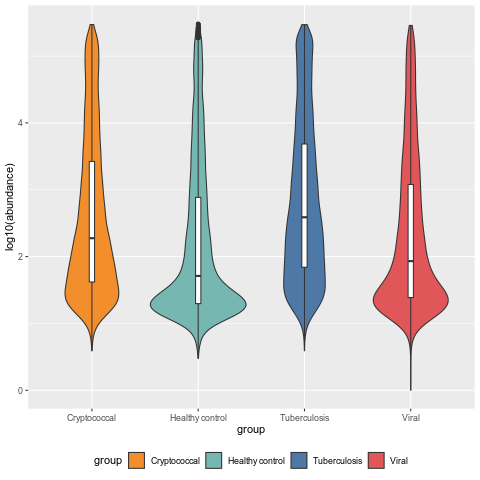

In [82]:
%%R
(
    ggplot(stacked, aes(x=group, y=log10(abundance), fill=group))
    + geom_violin()
    + geom_boxplot(fill='white', width=.05)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(legend.position='bottom')
)

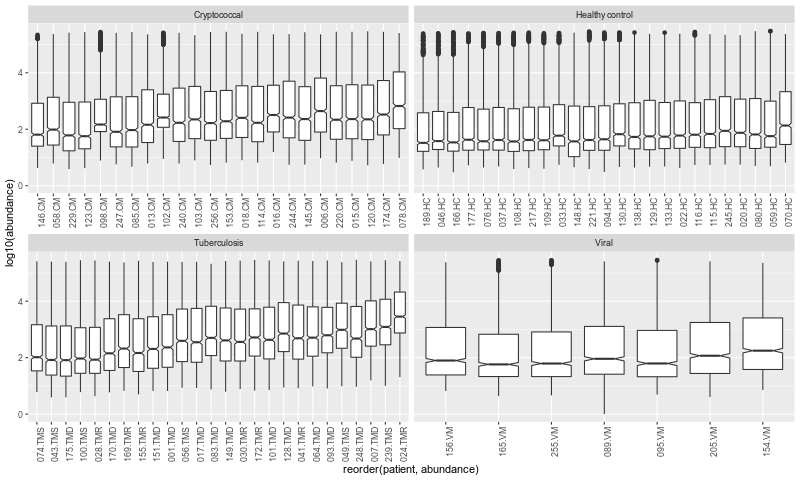

In [83]:
%%R -w 800
(
    ggplot(stacked, aes(x=reorder(patient, abundance), y=log10(abundance)))
    + facet_wrap('~ group', scale='free_x')
    + geom_boxplot(notch=T)
    + theme(axis.text.x = element_text(angle = 90))
)

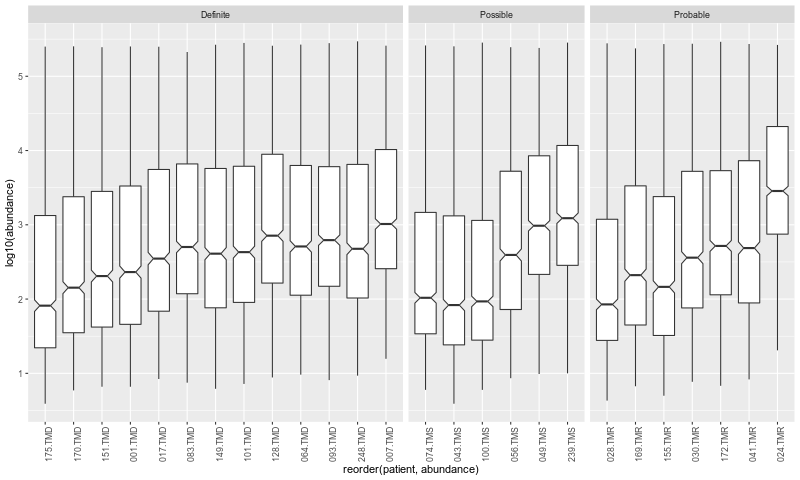

In [84]:
%%R -w 800
(
    ggplot(stacked[stacked$group == 'Tuberculosis',], aes(x=reorder(patient, abundance), y=log10(abundance)))
    + facet_grid('~ TB_status', scale='free_x', space='free_x')
    + geom_boxplot(notch=T)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(axis.text.x = element_text(angle = 90))
)

## Caveats of SOMAScan

A quick notes from [(Joshi and Mayr, 2018)](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.118.036823):
- non specificity, cross-reactivity a known problem
- SNPs a known problem too
- PTMs(!) a potential problem (IMO more than SNPs), an important consideration for signaling proteins and signaling pathways - these may be under-represented!

**Thus: (!!)**
Cross checking with RNA-seq is crucial and may hint us not only about the biological differences (i.e. SOMAScan detecting protein previously expressed and folded, while RNA-seq detecting proteins being actively expressed) but also about the discrepancies arising from failing SOMAScan failing to detect PTM modified signaling proteins or proteins bearing an important (and conformation changing) SNP.